这一次的修改主要有：   
（1）不分测试集    
（2）加入dropout    
（3）CPU2GPU      
CPU2GPU's     
reference:https://blog.csdn.net/qazwsxrx/article/details/89197067

In [1]:
import torch
import torch.optim
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
# 按照《Pytorch学习（三）定义自己的数据集及加载训练》：https://blog.csdn.net/sinat_42239797/article/details/90641659#commentBox
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import os
#读取数据
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.__version__

'1.1.0'

In [2]:
print torch.cuda.is_available() # 是否有已经配置好可以使用的GPU (若True则有)
print torch.cuda.device_count() # 可用GPU块数

True
1


In [3]:
#********数据集的设置********
root =os.getcwd()+ '/lmdb_source_data/'#数据集的地址
print(root)

txt = root+'depth2_list2.txt'#depth2_list2，有1100个数据 depth2_list，有1104个数据
x,y=[],[]
fh = open(txt,'r')
for line in fh: 
    line = line.strip('\n')
    line = line.rstrip('\n')
    words = line.split()
    x.append(words[0])
    y.append(int(words[1]))

/home/asber/Documents/RobotLearning/lmdb_source_data/


In [4]:
def default_loader(path):
        return Image.open(path)# 如果是我们的depth map 图片格式是L——灰度图。
    
class MyDataset(Dataset): 
#创建自己的类： MyDataset,这个类是继承的torch.utils.data.Dataset
     def __init__(self,x,y, transform=None,target_transform=None, loader=default_loader):
        super(MyDataset,self).__init__()#对继承自父类的属性进行初始化
        self.x = x
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        #*************************** #使用__getitem__()对数据进行预处理并返回想要的信息**********************
     def __getitem__(self, index):#这个方法是必须要有的，用于按照索引读取每个元素的具体内容
            fn, label = self.x[index],self.y[index]
            img = self.loader(root+'depth2/'+fn)# 按照路径读取图片
            if self.transform is not None:
                img = self.transform(img)#数据标签转换为Tensor
            return img,label#return回哪些内容，那么我们在训练时循环读取每个batch时，就能获得哪些内容
     def __len__(self):#这个函数也必须要写，它返回的是数据集的长度，也就是多少张图片，要和loader的长度作区分
            return len(self.x)

In [5]:
data=MyDataset(x=x,y=y, transform=transforms.ToTensor())
data_loader = DataLoader(dataset=data,\
                         batch_size=10,shuffle=True,num_workers=1)
print len(data)

1100


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layers1 = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=5,stride=1,padding=2),#1代表1个通道 32代表kernel数，kernelsize代表大小
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.layers2 = nn.Sequential(
            nn.Conv2d(32,32,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.layers3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(20*15*64,300),
            nn.ReLU(inplace=True),
            nn.Linear(300,5),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        x = self.layers1(x)
        x = self.layers2(x)
        x = self.layers3(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x

In [7]:
cnn = CNN()
error = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(),lr=0.0001)
cnn.cuda()

CNN(
  (layers1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layers2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layers3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=19200, out_features=300, bias=True)
    (1): ReLU(inplace)
    (2): Lin

In [10]:
data_num = float(len(data))
accuracy_list = []
for epochs in range(300):
    for i ,(img,label) in enumerate(data_loader):
        img = img.view(10,1,160,120)
        img = Variable(img).float().cuda()
        label = Variable(label).type(torch.LongTensor).cuda()
        optimizer.zero_grad()
        output = cnn(img)
        loss = error(output,label)
        loss.backward()
        optimizer.step()
    accuracy = 0
    for i ,(img,label) in enumerate(data_loader):
        img = img.view(10,1,160,120)
        img = Variable(img).float().cuda()
        out = cnn(img)
        pre = torch.max(out.data,1)[1]
        accuracy += (pre == Variable(label).type(torch.LongTensor).cuda()).sum()
    print('accuracy:',accuracy.item()/data_num)
    accuracy_list.append(accuracy.item()/data_num)
    if(accuracy.item()/data_num>0.81):
        torch.save(cnn.state_dict(),'./abcd.pth')
    if(accuracy.item()/data_num >= 0.86):
        break

('accuracy:', 0.8072727272727273)
('accuracy:', 0.8018181818181818)
('accuracy:', 0.8163636363636364)
('accuracy:', 0.8163636363636364)
('accuracy:', 0.8172727272727273)
('accuracy:', 0.8163636363636364)
('accuracy:', 0.81)
('accuracy:', 0.8190909090909091)
('accuracy:', 0.8263636363636364)
('accuracy:', 0.8218181818181818)
('accuracy:', 0.8354545454545454)
('accuracy:', 0.8172727272727273)
('accuracy:', 0.8245454545454546)
('accuracy:', 0.8363636363636363)
('accuracy:', 0.8218181818181818)
('accuracy:', 0.8290909090909091)
('accuracy:', 0.8345454545454546)
('accuracy:', 0.8245454545454546)
('accuracy:', 0.8236363636363636)
('accuracy:', 0.8336363636363636)
('accuracy:', 0.8372727272727273)
('accuracy:', 0.8381818181818181)
('accuracy:', 0.8354545454545454)
('accuracy:', 0.8372727272727273)
('accuracy:', 0.8454545454545455)
('accuracy:', 0.8409090909090909)
('accuracy:', 0.8427272727272728)
('accuracy:', 0.8445454545454546)
('accuracy:', 0.8472727272727273)
('accuracy:', 0.839090909090

Expected object of backend CUDA but got backend CPU for argument #2 'other'
代表在 accuracy += (pre == y).sum()的时候有一个变量其

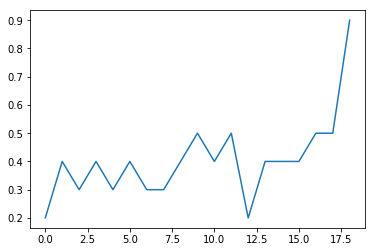

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(accuracy_list)
plt.show()

现在没有dropout，虽然测试集和训练集重合了，
但是拟合的还不错，的确是算力不够的问题，
现在把模型加载然后在gazebo中仿真。